## Exploratory Data Analysis on Embedding Point Clouds

In [49]:
from _collections_abc import Iterable

# File reading and loading
import glob
import re
import json

# Data analysis
import numpy as np
from scipy.spatial.distance import cdist

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from IPython.display import clear_output

In [3]:
def parse_json_filename(filename:str) -> tuple[str, list[tuple[str]]]:
    '''
    Parse JSON filesnames produced by CodeEmbeddingsGenerator.py
    into the classes, methods, and tokens they are located in.

    Args:
        filename: JSON filename to parse.
    
    Returns:
        level: Coding level of granularity (i.e., "class", "method", "token")
        identifiers: An ordered list of the nested classes, methods, and/or token.
    '''
    f = filename[:-5]
    nesting = []
    for m in re.finditer(r'(^|_)(c\.|m\.|token)', f):
        if (m.group() == 'c.') or (m.group() == '_c.'): level = 'class'
        elif (m.group() == 'm.') or (m.group() == '_m.'): level = 'method'
        elif (m.group() == 'token') or (m.group() == '_token'): level = 'token'
        else:
            print(f'Something has gone wrong! \n\tFilename: {filename}\n\tMatch: {m}')
            level = ''

        nesting.append((m.start(), m.end(), level))

    identifiers = []
    for i in range(1, len(nesting)):
        end = nesting[i]
        start = nesting[i-1]

        # Get identifier name and duplicate number 
        # (or just duplicate number if its a token)
        name = f[start[1] : end[0]]
        identifiers.append((name, start[2])) # Store name and level

    # Get last name and level
    last = nesting[-1]
    name = f[last[1]:] 
    identifiers.append((name, last[2]))

    # Return embedding level and parsing results
    return last[2], identifiers


def get_embedding_paths(sub_dirs:Iterable[str] = ['data'], 
                        levels:Iterable[str] = ['class', 'method', 'token'],
                        id_nestings:Iterable[tuple[str]] = []
                        ) -> tuple[list[str], list[str]]:
    '''
    Return file paths for JSON files created by CodeEmbeddingsGenerator.py.
    Collects all JSON files in a data folder by default.

    sub_dirs: Paths to subdirectories within the data folder to collect the JSON files from.
    levels: Embedding levels to collect (i.e., "class", "method", "token").
    id_nestings: Ordered lists of classes and/or methods that the code fragments associated with 
        the embeddings must be found in. The format must match that of the the 2nd output of 
        parse_json_filename().

    Returns:
        embed_paths: Paths to the JSON files.
        embed_levels: Embedding levels associated with each path in embed_paths.
    '''
    for level in levels:
        if level not in ('class', 'method', 'token'):
            print(f'Warning: Invalid level name "{level}".')
            
    embed_paths = []
    embed_levels = []
    for dir in sub_dirs:
        # Search through all JSON files
        for path in glob.glob(dir + '/**/*.json', recursive=True):
            filename = re.split(r'\\|/', path)[-1] # Get filename (and file extension)
            level, identifiers = parse_json_filename(filename) # Get embedding level and the nesting
            # Collect paths to embeddings of specified levels
            if level in levels:
                if len(id_nestings) == 0:
                    embed_paths.append(path)
                    embed_levels.append(level)
                    continue
                # Collect paths to embeddings that are nested in the specified classes and/or methods
                for nesting in id_nestings:
                    if nesting == identifiers[:len(nesting)]:
                        embed_paths.append(path)
                        embed_levels.append(level)
                        break
    return embed_paths, embed_levels


def paths_to_data(paths:Iterable[str], to_ndarray:bool = False) -> dict:
    '''
    Takes a list of directory paths to JSON files generated by CodeEmbeddingsGenerator.py, 
    then loads the data and compiles them into a single dictionary.

    Args:
        paths: The list of directory paths to JSON files.

    Returns:
        data: A dataset of embeddings, the associated identifier/token name, 
            the start and end indices for parsing the original code fragment,
            and the directory path to the JSON file.
    '''
    data = {'embeds':list(), 'names':list(), 'spans':list(), 'paths':list()}
    for path in paths:
        file = json.load(open(path, 'r'))
        data['embeds'].append(file[0][0]) # Embedding
        data['names'].append(file[1]) # Identifier or token name
        data['spans'].append(file[2]) # Start and end indices in source code
        data['paths'].append(path) # Path to file

    if to_ndarray:
        # Turn lists into numpy arrays
        for key in data.keys():
            data[key] = np.array(data[key])
    return data

In [44]:
# List of all directories to folders of JSON files
# These are the Java files in the original codebase
all_java_files = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in glob.glob("data\\**\\*.json", recursive=True)]))
all_java_files = sorted(all_java_files)

In [45]:
# List of all directories to folders of folders of JSON files
# These are the folders in the original codebase
all_folders = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in all_java_files]))
all_folders = sorted(all_folders)

### Class, Method, and Token Total Counts

In [28]:
paths, _ = get_embedding_paths(levels=['class'])
len(paths)

579

In [29]:
paths, _ = get_embedding_paths(levels=['method'])
len(paths)

5352

In [30]:
paths, _ = get_embedding_paths(levels=['token'])
len(paths)

378782

### Location Based on Distance From Origin (0,0,...,0)

In [15]:
def create_data_sets(dirs, levels):
    data_sets = [] # Sets of embeddings taken from their corresponding Java file
    for dir in dirs:
        paths, _ = get_embedding_paths(sub_dirs=[dir], levels=levels)
        data = paths_to_data(paths)

        # If the embedding directory yielded no embeddings, do not append the empty data
        if len(data['embeds']) != 0:
            data_sets.append(data)
    return data_sets


def show_dists_from_origin(embed_sets, ax=None):
    origin = np.zeros((768)) # All embeddings consist of 768 values

    # Run through every set of embeddings
    dist_sets = []
    for embeds in embed_sets:
        dists = cdist(embeds, [origin]).reshape(-1)
        dist_sets.append(dists)
            
    # Show average of all distances
    avg = np.mean([dist for dists in dist_sets for dist in dists])

    if ax == None:
        fig = plt.hist(dist_sets, histtype='step', color=['blue']*len(dist_sets), fill=True, alpha=0.05)
        plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
        return fig
    else:
        ax.hist(dist_sets, histtype='step', color=['blue']*len(dist_sets), fill=True, alpha=0.05)
        ax.axvline(avg, color='k', linestyle='dashed', linewidth=1)
        return

In [7]:
# Get class embeddings by the Java files from which they're derived
class_datasets = create_data_sets(dirs=all_java_files, levels=['class'])

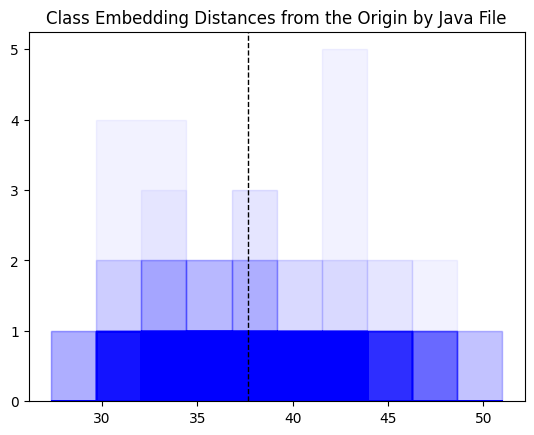

In [8]:
show_dists_from_origin([data['embeds'] for data in class_datasets])
plt.title("Class Embedding Distances from the Origin by Java File")
plt.show()

In [161]:
# Get method embeddings by the Java files from which they're derived
method_datasets = create_data_sets(dirs=all_java_files, levels=['method'])

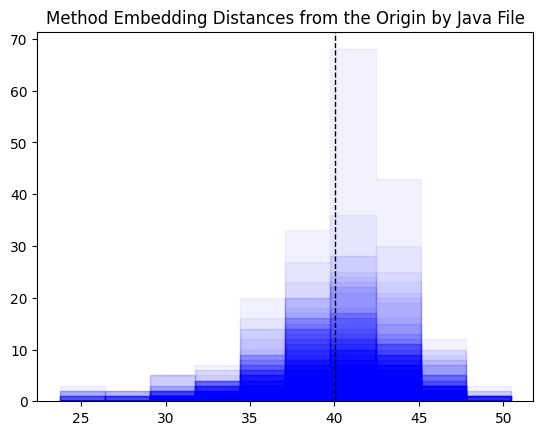

In [306]:
show_dists_from_origin([data['embeds'] for data in method_datasets])
plt.title("Method Embedding Distances from the Origin by Java File")
plt.show()

In [57]:
def plot_folder_sets(folder_sets, levels, title):
    n = len(all_folders) # There are 65 folders in the codebase (that have Java files)
    fig, ax = plt.subplots(nrows=int(n/5), ncols=5)
    fig.set_figwidth(14)
    fig.set_figheight(14*3)
    ax_reshaped = ax.reshape(-1)

    to_data = 'data'
    for i, folders in enumerate(folder_sets):
        clear_output()
        print(f"Working on folder set #{i}: {all_folders[i]}")

        folder_class_datasets = create_data_sets(dirs=folders, levels=levels)

        # If any number of embeddings were collected, plot histogram
        if len(folder_class_datasets) != 0:
            show_dists_from_origin([data['embeds'] for data in folder_class_datasets], ax=ax_reshaped[i])

        ax_reshaped[i].set_title(all_folders[i][len(to_data)+1 :], fontsize=10)

    print("Histograms complete. Finalizing figure...")
    
    fig.suptitle(title, y=1)
    fig.tight_layout()
    return fig 

In [20]:
n = len(all_folders)
n

65

In [9]:
# Get class/method embeddings by Java files from the immediate directories they're in
folder_sets = []
for dir in all_folders:
    json_files = glob.glob(dir + '/*/*.json') # JSON files contained in any subsequent folder of the current directory
    java = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in json_files])) # Folders in the current directory immediately containing JSON files 
    folder_sets.append(java)
    
folder_sets[0]

['data\\ivy\\Main', 'data\\ivy\\Ivy', 'data\\ivy\\Ivy14']

Working on folder set #64: data\ivy\util\url
Histograms complete. Finalizing figure...


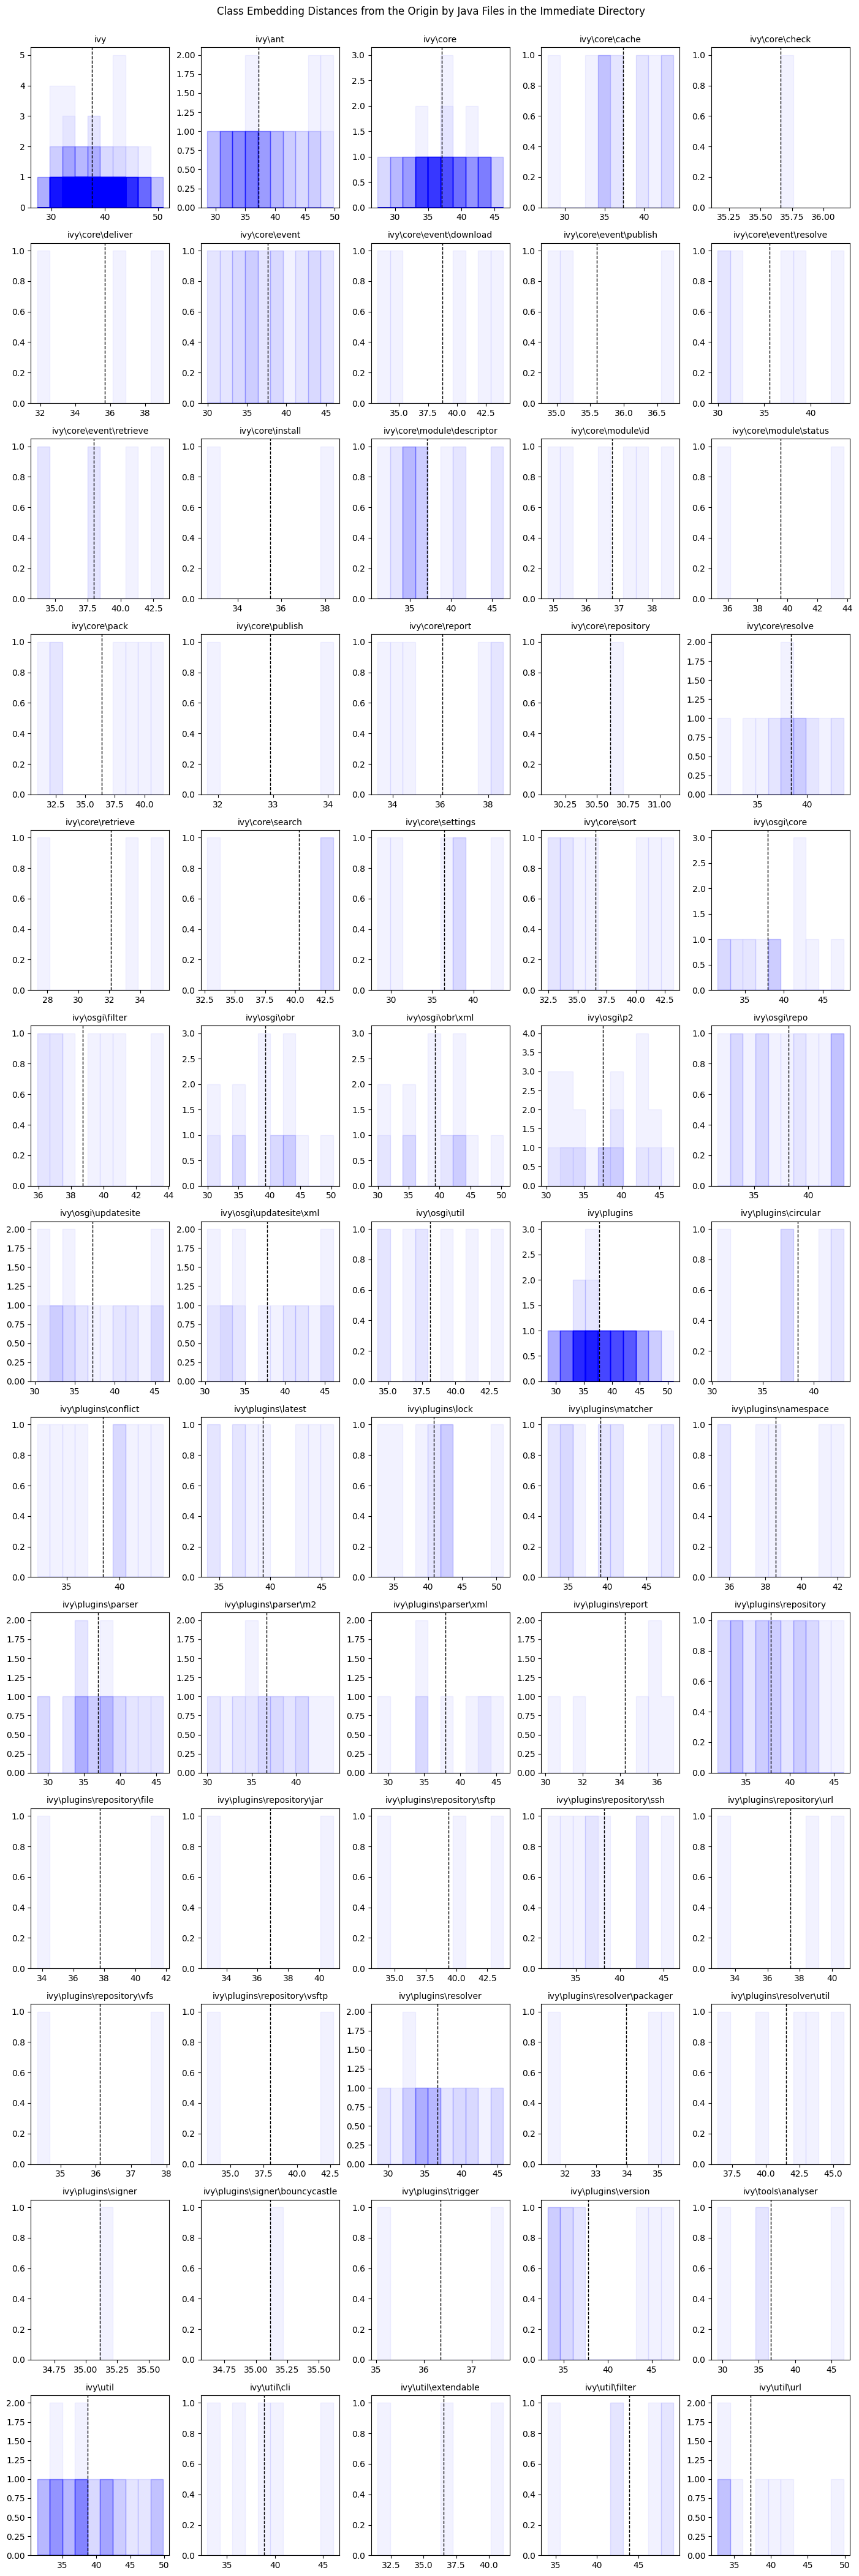

In [61]:
# Class
plot_folder_sets(folder_sets, levels=['class'],
                 title="Class Embedding Distances from the Origin by Java Files in the Immediate Directory")
plt.show()

Working on folder set #64: data\ivy\util\url
Histograms complete. Finalizing figure...


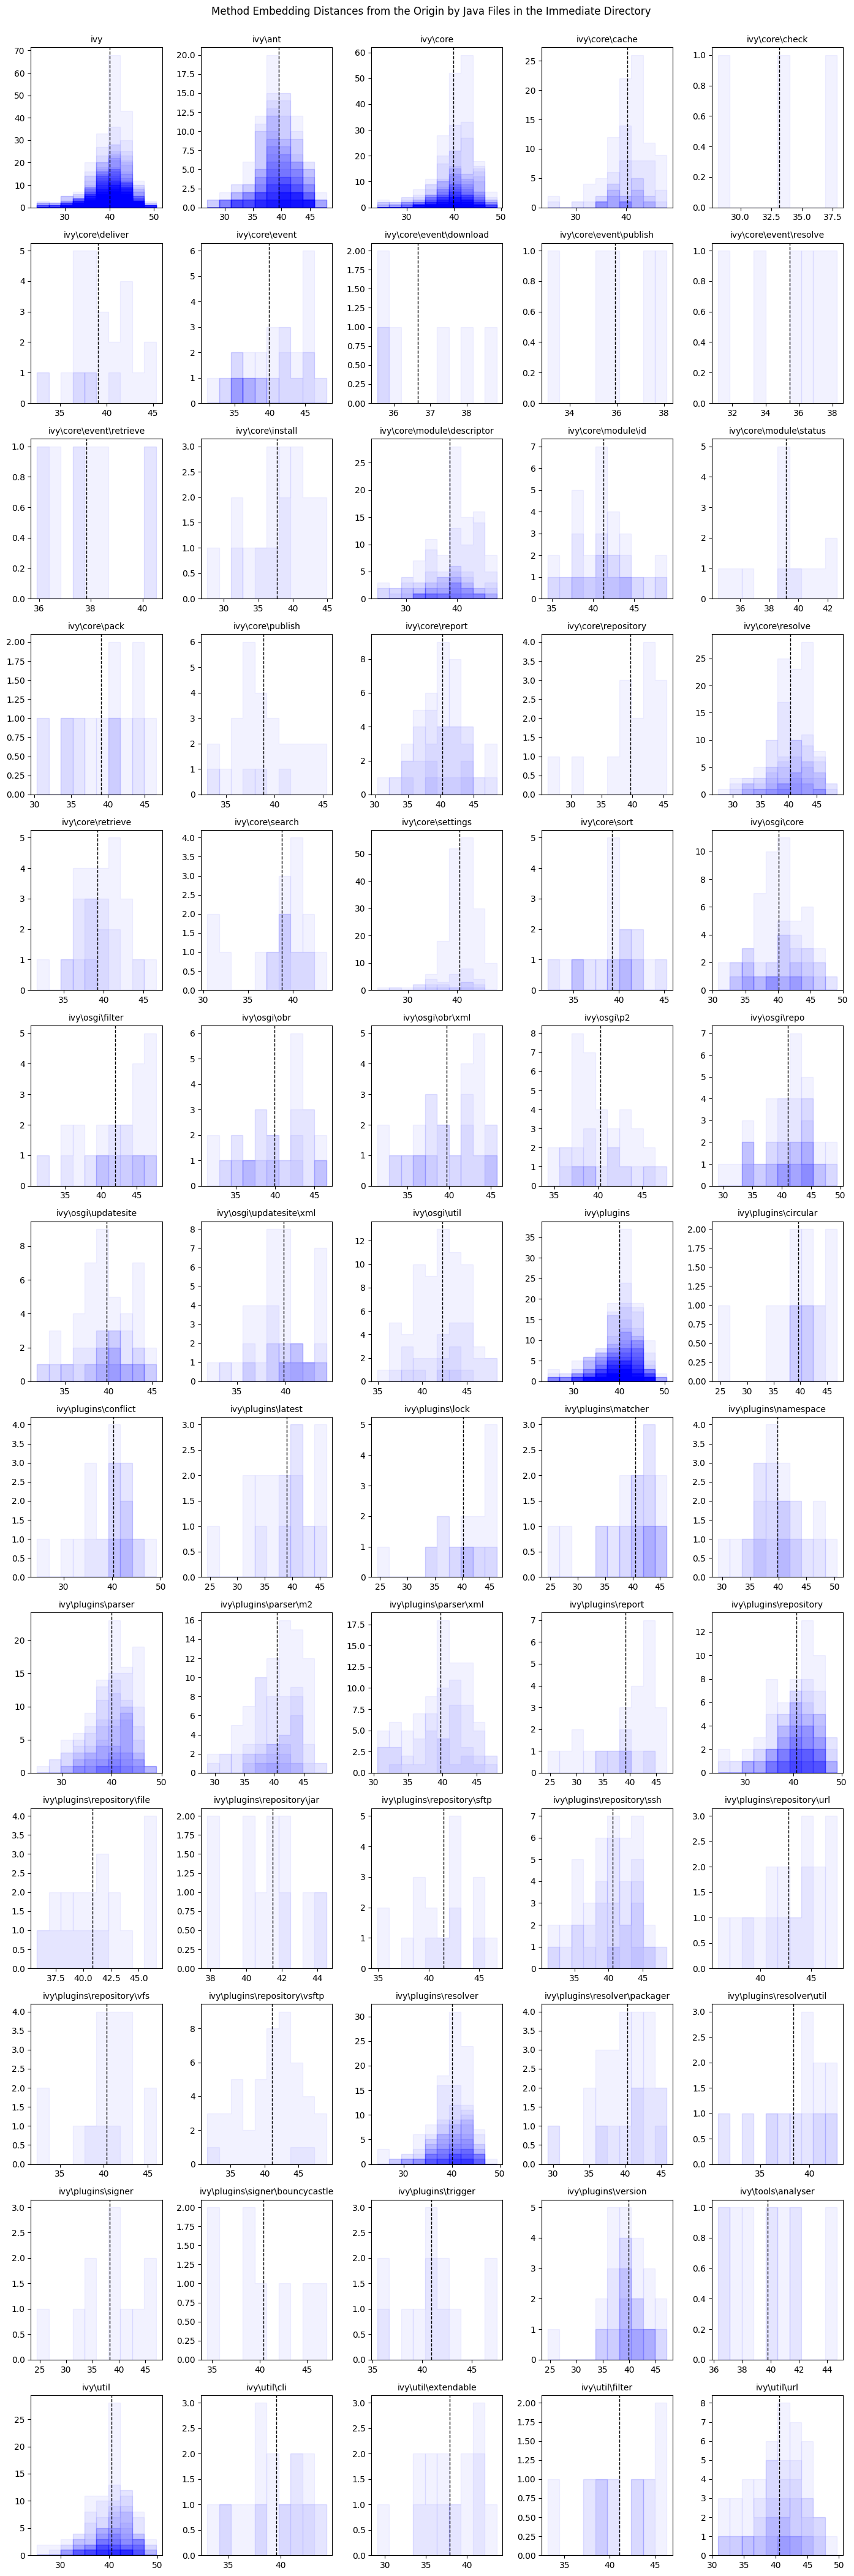

In [60]:
# Method
plot_folder_sets(folder_sets, levels=['method'],
                 title="Method Embedding Distances from the Origin by Java Files in the Immediate Directory")
plt.show()

In [42]:
# Get class/method embeddings by the Java files from the directories they're in (including any sub-directories of those directories)
folder_sets_recursive = []
for dir in all_folders:
    json_files = glob.glob(dir + '/**/*.json', recursive=True) # JSON files in the directory
    java = list(set(['\\'.join(dir.split('\\')[:-1]) for dir in json_files])) # Folders containing the JSON files in the directory 
    folder_sets_recursive.append(java)

Working on folder set #64: data\ivy\util\url
Histograms complete. Finalizing figure...


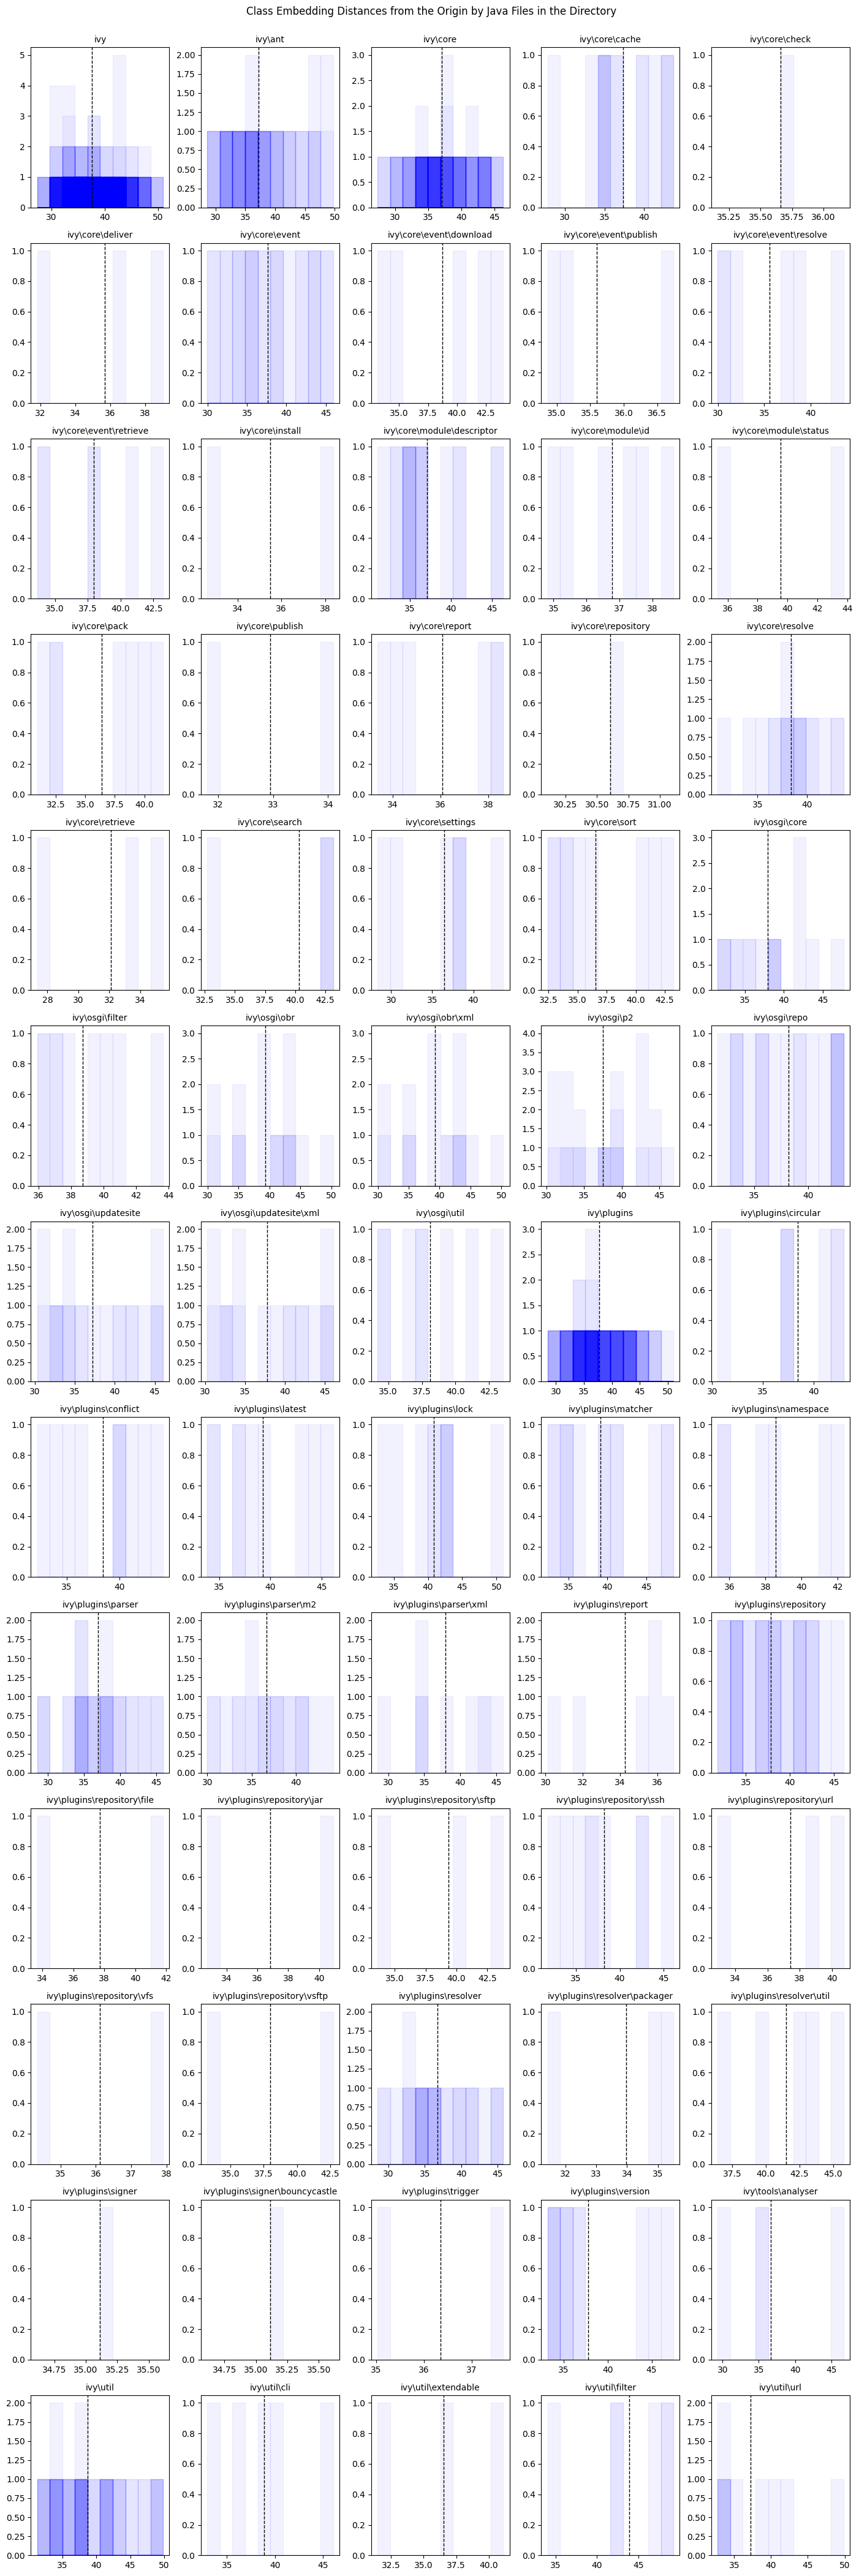

In [59]:
# Class
plot_folder_sets(folder_sets_recursive, levels=['class'],
                 title="Class Embedding Distances from the Origin by Java Files in the Directory")
plt.show()

Working on folder set #64: data\ivy\util\url
Histograms complete. Finalizing figure...


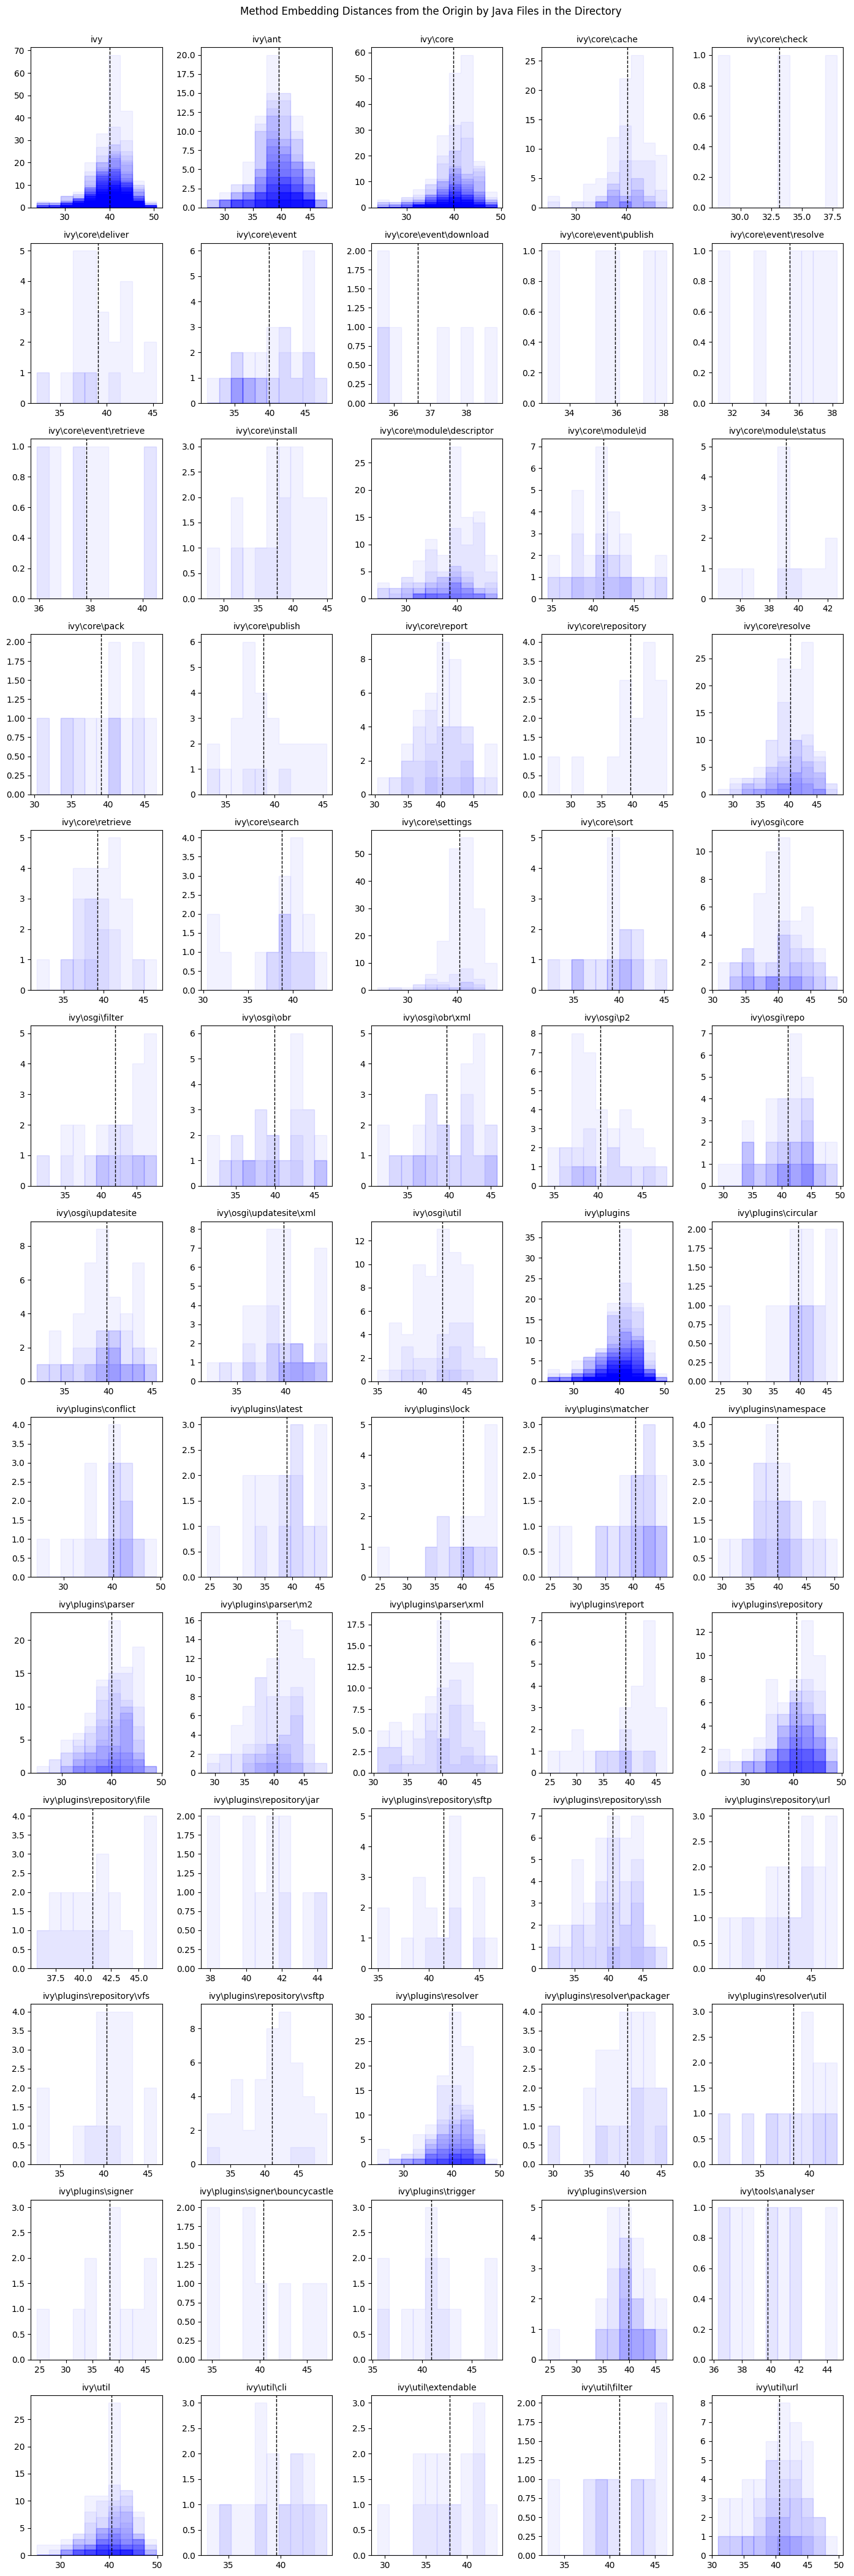

In [58]:
# Method
plot_folder_sets(folder_sets_recursive, levels=['method'],
                 title="Method Embedding Distances from the Origin by Java Files in the Directory")
plt.show()

In [80]:
# Token time
paths, _ = get_embedding_paths(sub_dirs=['data/ivy/Ivy'], levels=['token'])
data = paths_to_data(paths)

In [94]:
[i for i, name in enumerate(data['names']) if name == ';']

[6,
 58,
 61,
 66,
 91,
 125,
 128,
 147,
 151,
 175,
 193,
 213,
 235,
 257,
 271,
 277,
 284,
 290,
 306,
 324,
 342,
 351,
 364,
 387,
 396,
 412,
 425,
 433,
 447,
 453,
 460,
 464,
 472,
 486,
 492,
 499,
 503,
 511,
 527,
 534,
 541,
 546,
 553,
 573,
 580,
 587,
 592,
 600,
 627,
 644,
 652,
 661,
 683,
 690,
 717,
 731,
 739,
 757,
 761,
 778,
 786,
 798,
 809,
 816,
 827,
 835,
 851,
 861,
 871,
 881,
 892,
 897,
 916,
 926,
 936,
 946,
 952,
 970,
 980,
 990,
 1000,
 1010,
 1015,
 1021,
 1030,
 1038,
 1056,
 1081,
 1098,
 1106,
 1126,
 1138,
 1157,
 1178,
 1185,
 1194,
 1196,
 1205,
 1259,
 1270,
 1276,
 1286,
 1299,
 1306,
 1317,
 1324,
 1343,
 1350,
 1363,
 1371,
 1392,
 1405,
 1413,
 1430,
 1441,
 1446,
 1455,
 1463,
 1476,
 1485,
 1493,
 1508,
 1519,
 1526,
 1544,
 1557,
 1565,
 1588,
 1601,
 1608,
 1623,
 1629,
 1633,
 1653,
 1660,
 1667,
 1670,
 1679,
 1698,
 1721,
 1756,
 1784,
 1802,
 1810,
 1836,
 1848,
 1864,
 1879,
 1887,
 1910,
 1918,
 1923,
 1931,
 1967,
 1990,
 